## Graph Neural Network for Estimation of Minimum Spanning Tree value

We use code from Thomas Kipf and Max Welling available at https://github.com/tkipf/gcn for the graph convolutional network and Tensorflow for the neural network backend.

The network is trained on examples of graphs and their corresponding minimum spanning tree (MST) values and can accurately predict, in the testing phase, the MST value for previously unseen graphs of similar size and the same fundamental structure.

In [1]:
# Python 3 compatibility
from __future__ import division
from __future__ import print_function
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# neural network and graph convolutional NN packages
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model, MLP
from gcn.layers import *

# for turning real graphs into features
import networkx as nx
from scipy.sparse import csc_matrix, csr_matrix
import numpy as np

# logging
import time
from datetime import datetime
import os
import csv
# plotting (inline in notebook)
import matplotlib.pyplot as plt
%matplotlib inline

# Graph convolution layer and GCN class declarations
Includes loss and accuracy metrics.

In [2]:
# --------------------------------
# Redefine GraphConvolution layer and GCN class
# Changes: 
#     - added capability to GraphConvolution layer to selectively use weighted adjacency
#     - brought loss and accuracy metrics into GCN class
#     - added capability to GCN class to build layers according to argument specification
# --------------------------------

class GraphConvolution(Layer):
    """Graph convolution layer."""
    def __init__(self, input_dim, output_dim, placeholders, adjacency='B',
                 dropout=False, sparse_inputs=False, act=tf.nn.relu, bias=False,
                 featureless=False, **kwargs):
        """
        Constructor for graph convolution neural network layer, which uses graph structure,
            via support matrix, to enhance connectivity of NN nodes.
        :param input_dim: layer input dimension
        :param output_dim: layer output dimension
        :param placeholders: needed for dropout probability and supports (weighted and ones)
        :param dropout: T/F to activate dropout (prob. = placeholders['dropout']) on layer
        :param act: activation function
        :return: None
        """
        super(GraphConvolution, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.
        
        self.A = 'a' in adjacency.lower()
        self.B = 'b' in adjacency.lower()
        assert self.A or self.B, "Adjacency must use any/all of A or B matrices"
        
        self.act = act
        self.support = placeholders['support']
        self.support_ones = placeholders['support_ones']
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            for i in range(len(self.support)):
                self.vars['weights_A_' + str(i)] = glorot([input_dim, output_dim],
                                                        name='weights_A_' + str(i))
                self.vars['weights_B_' + str(i)] = glorot([input_dim, output_dim],
                                                        name='weights_B_' + str(i))
                self.vars['weights_tilde_' + str(i)] = glorot([1, output_dim],
                                                              name='weights_tilde_' + str(i))
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            # keep probability is (1 - self.dropout)
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # convolve
        supports = list()
        for i in range(len(self.support)):
            if not self.featureless:
                pre_sup_A = dot(x, self.vars['weights_A_' + str(i)], sparse=self.sparse_inputs)
                pre_sup_B = dot(x, self.vars['weights_B_' + str(i)], sparse=self.sparse_inputs)
            else:
                pre_sup_A = self.vars['weights_A_' + str(i)]
                pre_sup_B = self.vars['weights_B_' + str(i)]
            if self.B:
                support = dot(self.support[i], pre_sup_B, sparse=True)
                if self.A:
                    support += dot(self.support_ones[i], pre_sup_A, sparse=True)
                    support /= 2.
            elif self.A:
                support = dot(self.support_ones[i], pre_sup_A, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)


class GCN(Model):
    """
    Graph convolutional neural network class
    """
    def __init__(self, placeholders, input_dim, layer_config, dropouts, learning_rate, weight_decay, **kwargs):
        """
        Constructor for graph convolutional neural network, defined by the layer_config.
        :param placeholders: contains features, labels, masks, supports, and dropout probability.
        :param input_dim: neural network input dimension (= number of graph nodes)
        :param layer_config: list of tuples (layer type, dimension, support type) that define NN structure
        :param dropouts: list of T/F that corresponds to NN layers and turns on dropout
        :param learning_rate: optimizer learning rate
        :param weight_decay: decay applied to L2 loss
        :return: None
        """
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        
        # for regression change output dimension to 1
        self.output_dim = 1
        
        self.layer_config = layer_config
        self.dropouts = dropouts
        assert len(self.layer_config) == len(self.dropouts), "layer_config and dropouts must align in length"
        self.placeholders = placeholders
        self.weight_decay = weight_decay

        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

        self.build()
    
    @staticmethod
    def masked_mean_square_error(preds, labels, mask):
        """
        Calculate MSE between predictions and labels.
        """
        # take square of difference between predictions and labels
        loss = tf.squared_difference(preds, labels)
        # sum differences within each observation
        loss = tf.reduce_sum(loss, 1)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        # apply mask
        loss *= mask
        # report mean loss per observation
        return tf.reduce_mean(loss)
    
    @staticmethod
    def masked_accuracy(preds, labels, mask):
        """
        Calculate MAE between predictions and labels.
        """
        # take absolute of difference between predictions and labels
        loss = tf.sqrt(tf.squared_difference(preds, labels))
        # sum differences within each observation
        loss = tf.reduce_sum(loss, 1)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        # apply mask
        loss *= mask
        # report mean loss per observation
        return tf.reduce_mean(loss)
    
    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += self.weight_decay * tf.nn.l2_loss(var)
        self.loss += GCN.masked_mean_square_error(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        # reported accuracy
        self.accuracy = GCN.masked_accuracy(self.outputs, self.placeholders['labels'],
                                            self.placeholders['labels_mask'])

    def _build(self):
        """
        Construct the NN according to the layer_config defined for the class.
        """
        for (lt, ls, lo), d, li in zip(self.layer_config, self.dropouts, range(len(self.layer_config))):
            if li == 0:
                in_dim = self.input_dim
                si = True
            else:
                in_dim = self.layer_config[li-1][1]
                si = False
            if li == len(self.layer_config):
                out_dim = self.output_dim
            else:
                out_dim = ls
            
            if lt.lower() in ("gc", "graph", "graphconvolution"):
                self.layers.append(GraphConvolution(input_dim=in_dim, output_dim=out_dim,
                                                    placeholders=self.placeholders, adjacency=lo, 
                                                    act=tf.nn.relu, dropout=d, sparse_inputs=si, 
                                                    logging=self.logging))
            elif lt.lower() in ('d', 'dense'):
                self.layers.append(Dense(input_dim=in_dim, output_dim=out_dim,
                                         placeholders=self.placeholders, act=tf.nn.relu,
                                         dropout=d, sparse_inputs=si, logging=self.logging))

    def predict(self):
        """
        Return NN outputs directly (no softmax).
        """
        # pass outputs directly back, since this is set up for regression
        return self.outputs


# New class to generate data and access/train GCN

In [3]:
# --------------------------------
# New MST_GCN class to leverage GCN to predict value of minimum spanning tree (MST)
# --------------------------------

class MST_GCN:
    """
    MST_GCN uses a graph convolutional neural network to predict the value of 
    a graph minimum spanning tree.
    """
    def __init__(self, dropout=0.5, epochs=200, learning_rate=0.01, 
                 weight_decay=5e-4, early_stopping=100, log=False, logstring=''):
        """
        Class need only be constructed once. Hyperparameters may be updated, 
        data may be regenerated, and model may be retrained using a single instance.
        :param dropout: probability of NN node not being activated
        :param epochs: limit of training steps for convergence
        :param learning_rate: optimizer learning rate
        :param weight_decay: decay applied to L2 loss
        :param early_stopping: minimum number of epochs reached before early stop is possible
        :param log: T/F to turn on logging of results for all training performed
        :param logstring: additional information on log header for record keeping
        :return: None
        """
        # Set random seed
        seed = 123
        np.random.seed(seed)
        tf.set_random_seed(seed)
        
        # Set class initialized log file name
        if log:
            if 'logs' not in os.listdir('./'):
                os.mkdir('./logs')
            self.logfn = "./logs/gcn_trial_{}.txt".format(datetime.now().strftime("%m-%d-%y_%H%M%S"))
            self.csvfn = os.path.splitext(self.logfn)[0] + '.csv'
            with open(self.logfn, 'w') as f:
                f.write("MST GCN trial: {}\n".format(self.logfn))
                f.write(logstring + '\n')
            with open(self.csvfn, 'w') as f:
                f.write("MST GCN trial: {}\n".format(self.logfn))
                f.write(logstring + '\n')
        else:
            self.logfn = None
            self.csvfn = None
        
        # modeling/optimization settings        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.early_stopping = early_stopping
        
        # allocations of training, validation, and testing data
        self.val_range = None
        self.train_range = None
        self.test_range = None
        
        self.n_nodes = None
        self.beta = None
        
        # masks (trivial as implemented)
        self.train_mask = None
        self.val_mask = None
        self.test_mask = None
        
        # data for modelling
        self.graphs = None
        self.mst_vals = None
        self.adjs = None
        self.y_values = None
        self.featureset = None
        self.features = None
        self.feature_length = None
        self.supports = None
        self.supports_ones = None
        self.num_supports = None
        self.placeholders = None
        
        # modelling results
        self.train_loss = []
        self.validation_loss = []
        self.train_accuracy = []
        self.validation_accuracy = []
        self.test_cost = []
        self.test_acc = []
        self.test_pct_acc = []
    
    def update_params(self, dropout=0.5, learning_rate=0.01, weight_decay=5e-4):
        """
        Update parameters of class for GCN construction.
        :return: None
        """
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
    
    @staticmethod
    def generate_graph(n, beta):
        """
        Make one Waxman graph.
        :param n: number of nodes in the graph
        :return: graph, value of MST
        """
        # random Waxman graph from NetworkX
        g = nx.waxman_graph(n, beta)
        n = {i: d for i, d in g.nodes(data=True)}
        for node, p in g.nodes(data=True):
            if g.degree(node) > 0:
                continue
            else:
                d = [np.power(np.sum(np.power(np.array(p['pos']) - np.array(d['pos']), 2)), 0.5) if u != node else 1000.
                     for u, d in g.nodes(data=True)]
                neighbor = np.argmin(np.array(d))
                g.add_edge(node, neighbor)
        while not nx.is_connected(g):
            c = sorted(list(nx.connected_components(g)), key=lambda x: len(x))
            s = c[0]
            mn = (None, None, 10000.)
            for sn in c[1]:
                d = [(np.power(np.sum(np.power(np.array(g.node[sn]['pos']) - np.array(g.node[u]['pos']), 2)), 0.5), u)
                     for u in s]
                d.sort(key=lambda x: x[0])
                if d[0][0] < mn[2]:
                    mn = (sn, d[0][1], d[0][0])
            g.add_edge(mn[0], mn[1])
        # assign weight to each edge by its length (L2 distance between nodes)
        for u, v, d in g.edges(data=True):
            d['weight'] = np.power(np.sum(np.power(np.array(n[u]['pos']) - np.array(n[v]['pos']), 2)), 0.5)
        # calculate value of weighted minimum spanning tree
        m = nx.minimum_spanning_tree(g, weight='weight')
        mv = sum([d['weight'] for u, v, d in m.edges(data=True)])
        return g, mv

    def generate_graphs(self, n_graphs, n_nodes, beta):
        """
        Generate a bunch of Waxman graphs and calculate minimum spanning tree values, 
            weighted adjacency matrices, and unweighted adjacency matrices.
        :param n_graphs: number of graphs
        :param n_nodes: number of nodes in each graph
        :return: list of graphs, list of MST values, list of w. adj., list of u.w. adj.
        """
        if type(n_nodes) in (int, float):
            sizes = [n_nodes]*n_graphs
        elif type(n_nodes) in (list, tuple) and len(n_nodes) == n_graphs:
            sizes = n_nodes
        else:
            raise ArgumentError("Problem with n_nodes argument.")
        # make a bunch of Waxman graphs
        graphs, mst_vals = zip(*[MST_GCN.generate_graph(n=s, beta=beta) for _, s in zip(range(n_graphs), sizes)])
        # compute weighted adjacency matrices
        adjs = [csr_matrix(np.lib.pad(nx.adjacency_matrix(g, weight='weight').toarray(), 
                                      ((0, self.n_nodes - nx.number_of_nodes(g)), (0, self.n_nodes - nx.number_of_nodes(g))), 
                                      'constant', constant_values=0)) for g in graphs]
        # compute unweighted adjacency matrices
        adjs_ones = [csr_matrix(np.lib.pad(nx.adjacency_matrix(g, weight=None).toarray(), 
                                           ((0, self.n_nodes - nx.number_of_nodes(g)), (0, self.n_nodes - nx.number_of_nodes(g))), 
                                           'constant', constant_values=0)) for g in graphs]
        return graphs, mst_vals, adjs, adjs_ones

    def _evaluate(self, features, support, support_ones, labels, mask, placeholders):
        """
        Model evaluation function for validation and testing of NN.
        :return: loss, accuracy, evaluation time elapsed
        """
        # take down start time
        t_test = time.time()
        # construct feed dictionary with new values
        feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
        # update with dropout probability and unweighted support matrix
        feed_dict_val.update({self.placeholders['dropout']: self.dropout})
        feed_dict_val.update({self.placeholders['support_ones'][i]: support_ones[i] 
                              for i in range(len(support_ones))})
        # run through NN
        outs_val = self.sess.run([self.model.loss, self.model.accuracy], feed_dict=feed_dict_val)
        return outs_val[0], outs_val[1], (time.time() - t_test)
    
    @staticmethod
    def _normalize_adj(adj, sparse):
        """Symmetrically normalize adjacency matrix."""
        if sparse:
            adj = sp.coo_matrix(adj)
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt, 0)
        return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    
    @staticmethod
    def _preprocess_adj(adj, neighbor_degree, sparse=True):
        """
        Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation.
        :return: preprocessed adjacency matrix as tuple (from sparse matrix)
        """
        if neighbor_degree == 1:
            # first-degree neighbor adjacency A^1
            adj_normalized = MST_GCN._normalize_adj(adj + sp.eye(adj.shape[0]), sparse=True)
            return sparse_to_tuple(adj_normalized)
        elif neighbor_degree == 2:
            # second-degree neighbor adjacency A^2
            adj_square = np.power(adj, 2).tocoo()
            return sparse_to_tuple(adj_square)
        else:
            raise NotImplementedError("neighbor_degree > 2 not implemented at this time")
    
    def generate_data(self, n_graphs, n_nodes, train_frac, val_frac, beta, test_n_nodes=None):
        """
        Generate the graph data and split into training, validation, and testing.
            Graphs remaining after training and validation allocation are used for testing.
        :param n_graphs: number of graphs
        :param n_nodes: number of nodes in each graph
        :param train_frac: fraction of graphs to use for training
        :param val_frac: fraction of graphs to use for validation
        :return: None
        """
        print("Generating data.")
        # make sure new data clears features
        self.featureset = None
        self.features = None
        self.n_nodes = n_nodes
        # calculate indices for ranges
        # right now validation is first range because of random seed in NetworkX
        assert train_frac + val_frac <= 1
        val_idx = int(n_graphs*val_frac)-1
        train_idx = int(n_graphs*(train_frac + val_frac))-1
        # create the three non-overlapping ranges of indices for training, validation, and testing
        self.val_range = range(0, val_idx)
        self.train_range = range(val_idx, train_idx)
        self.test_range = range(train_idx, n_graphs-1)
        # masks are [1] because only one graph is passed at a time to train/validate/test (correct to type)
        self.train_mask = np.array([1])
        self.val_mask = np.array([1])
        self.test_mask = np.array([1])
        #
        if test_n_nodes is None or test_n_nodes == n_nodes:
            pass
        elif test_n_nodes < n_nodes:
            n_nodes = [n_nodes if i < int(n_graphs*(train_frac + val_frac))-1 else test_n_nodes for i in range(n_graphs)]
        else:
            raise ArgumentError("test_n_nodes > n_nodes")
        # generate graphs
        self.graphs, self.mst_vals, self.adjs, self.adjs_ones = self.generate_graphs(n_graphs=n_graphs, n_nodes=n_nodes, beta=beta)
        # make each y-value an array - will only train/validate/test on one at a time
        self.y_values = np.array([np.array([l]).reshape(1, 1) for l in self.mst_vals])
    
    def generate_features(self, feature_gen):
        """
        Generate specified feature vectors for nodes in each graph.
            Available features: 'degree', 'weighted_degree', 'weighted_second_degree', 'adj', 'path'
        :param feature_gen: list of features to generate for each node of each graph
        :return: None
        """
        print("Generating features.")
        self.featureset = feature_gen
        features = []
        for g in self.graphs:
            vecs = []
            if 'degree' in feature_gen:
                # unweighted degree of on-hop neighborhood
                degrees = [g.degree(n, weight=None) for n in g.nodes()]
                d_vec = ((np.array(degrees) - min(degrees)) / (max(degrees) - min(degrees))).reshape(len(degrees), 1)
                vecs.append(d_vec)
            if 'weighted_degree' in feature_gen:
                # weighted degree of one-hop neighborhood
                w_degrees = [g.degree(n, weight='weight') for n in g.nodes()]
                wd_vec = ((np.array(w_degrees) - min(w_degrees)) / (max(w_degrees) - min(w_degrees))).reshape(len(w_degrees), 1)
                vecs.append(wd_vec)
            if 'weighted_second_degree' in feature_gen:
                # weighted degree of two-hop neighborhood
                w2_degrees = [sum([g.degree(n2, weight='weight') for n2 in g.neighbors(n) if n2 != n]) for n in g.nodes()]
                wd2_vec = ((np.array(w2_degrees) - min(w2_degrees)) / (max(w2_degrees) - min(w2_degrees))).reshape(len(w2_degrees), 1)
                vecs.append(wd2_vec)
            if 'adj' in feature_gen:
                padn = self.n_nodes - nx.number_of_nodes(g)
                adj_vecs = list(np.lib.pad(nx.adjacency_matrix(g, weight=None).toarray(), ((0, padn), (0, padn)), 
                                           'constant', constant_values=0))
                vecs.extend([av.reshape(len(av), 1) for av in adj_vecs])
            if 'path' in feature_gen:
                # define the feature matrix as the weighted shortest path length between nodes
                #####
                # TODO: get this to the proper size for undersized test graphs
                #####
                paths = list(np.array([[nx.single_source_dijkstra_path_length(g, n1, weight='weight').get(n2, 0) 
                                        for n2 in g.nodes()] for n1 in g.nodes()]))
                vecs.extend([p.reshape(len(p), 1) for p in paths])
            
            new_vecs = []
            for fv in vecs:
                if fv.shape[0] < self.n_nodes:
                    new_vecs.append(np.lib.pad(fv, ((0,int(self.n_nodes - len(fv))), (0,0)), 'constant', constant_values=0))
                else:
                    new_vecs.append(fv)
            # concatenate feature vectors, which should each be of length n_nodes
            f_vec = np.concatenate(new_vecs, axis=1)
            # get correct second dimension
            try:
                dim2 = f_vec.shape[1]
            except IndexError:
                # when only one feature is generated
                dim2 = 1
            # change feature matrix to sparse matrix for compatibility with GCN preprocess_features(.) function
            features.append(csc_matrix(f_vec.reshape(f_vec.shape[0], dim2)))
        # feature preprocessing (GCN utility)
        self.features = [preprocess_features(f) for f in features]
    
    def generate_supports(self, neighbor_degree=1):
        """
        Generate the support matrices for each graph, weighted and unweighted.
        :return: None
        """
        # adjacency matrices with edge weight
        self.supports = [[MST_GCN._preprocess_adj(b, neighbor_degree=neighbor_degree)] for b in self.adjs]
        # adjacency matrices without edge weights (zeros and ones)
        self.supports_ones = [[MST_GCN._preprocess_adj(a, neighbor_degree=neighbor_degree)] for a in self.adjs_ones]
        # hard coded because ability to generate multiple supports is not implemented
        self.num_supports = 1
        # Define placeholders
        self.placeholders = {
            'support': [tf.sparse_placeholder(tf.float32) for _ in range(self.num_supports)],
            'support_ones': [tf.sparse_placeholder(tf.float32) for _ in range(self.num_supports)],
            # use the first feature vector (sparse matrix representation) at index [0] and get the shape at index [2]
            'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(self.features[0][2], dtype=tf.int64)),
            'labels': tf.placeholder(tf.float32, shape=(None, 1)),
            'labels_mask': tf.placeholder(tf.int32),
            'dropout': tf.placeholder_with_default(0., shape=()),
            'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
        }

    def train_model(self, n_graphs, n_nodes, train_frac, val_frac, layer_config, dropouts,
                    feature_gen=['weighted_degree'], beta=0.8, test_n_nodes=None, 
                    force_regen_data=False, force_regen_supports=False, verbose=False):
        """
        Build specified NN and perform model training, validation, and testing.
            Graphs not allocated to training or validation are used for testing.
        :param n_graphs: number of graphs
        :param n_nodes: number of nodes in each graph
        :param train_frac: fraction of graphs used for training
        :param val_frac: fraction of graphs sued for validation
        :param layer_config: list of tuples (layer type, size, support) specifying NN structure
        :param dropouts: list of T/F aligning to layers that turn on/off dropout by layer
        :param feature_gen: list of features to generate for each node in each graph
        :param force_regen_data: T/F force regenerate data
        :param force_regen_support: T/F force regenerate supports
        :param verbose: print NN training progress
        :return: None
        """
        
        # make sure layer configuration and dropout configuration are of valid types
        try:
            s1 = "layer_config should be list of tuples of form (layer type, layer size)"
            assert all([type(lt) is str and type(ls) is int and type(lo) is str for lt, ls, lo in layer_config]), s1
            s2 = "dropouts should be iterable, corresponding to each layer"
            assert all([d in (True, False) for d in dropouts]) and len(dropouts) == len(layer_config), s2
        except BaseException as e:
            # to catch exception when layer_config is not iterable of iterables (each of size 2)
            # or dropouts is not iterable
            print("layer_config should be list of tuples of form (layer type, layer size)")
            raise e
        
        # only generate data if not in place or if forced to regenerate
        regen_data = self.y_values is None or self.n_nodes != n_nodes or (self.n_nodes != test_n_nodes and test_n_nodes is not None) or self.beta != beta or force_regen_data
        if regen_data:
            self.beta = beta
            self.generate_data(n_graphs, n_nodes, train_frac, val_frac, beta=beta, test_n_nodes=test_n_nodes)
        
        # only regenerate features when a new featureset is specified or when data is regenerated
        if self.featureset != feature_gen or self.features is None or regen_data:
            self.generate_features(feature_gen=feature_gen)
        
        # only generate supports if not in place or if forced to regenerate (data or supports)
        if self.supports is None or regen_data or force_regen_supports:
            self.generate_supports()
        
        # Create model
        # send layer configuration and dropouts specific to this model training run
        # use first feature vector at index [0] and get the shape at index [2] and the column dimension of the shape
        self.model = GCN(placeholders=self.placeholders, input_dim=self.features[0][2][1], 
                         layer_config=layer_config, dropouts=dropouts,
                         learning_rate=self.learning_rate, weight_decay=self.weight_decay, logging=True)
        
        # Initialize session
        self.sess = tf.Session()
        # Initialize weights
        self.sess.run(tf.global_variables_initializer())
        
        self.train_loss = []
        self.validation_loss = []
        self.train_accuracy = []
        self.validation_accuracy = []
        self.test_cost = []
        self.test_acc = []
        self.test_pct_acc = []
        
        # Train model
        print("Starting optimization...")
        for epoch in range(self.epochs):
            # TRAINING PHASE for epoch
            epoch_outs = []
            for graph_i in self.train_range:
                t = time.time()
                # Construct feed dictionary
                feed_dict = construct_feed_dict(self.features[graph_i], self.supports[graph_i], 
                                                self.y_values[graph_i], self.train_mask, self.placeholders)
                # update with dropout probability and unweighted support matrix
                feed_dict.update({self.placeholders['dropout']: self.dropout})
                feed_dict.update({self.placeholders['support_ones'][i]: self.supports_ones[graph_i][i] 
                                  for i in range(len(self.supports_ones[graph_i]))})
                # NN training
                outs = self.sess.run([self.model.opt_op, self.model.loss, self.model.accuracy], feed_dict=feed_dict)
                epoch_outs.append(outs)
            
            # VALIDATION PHASE for epoch
            epoch_costs = []
            epoch_acc = []
            epoch_dur = []
            for graph_i in self.val_range:
                # Validation
                cost, acc, duration = self._evaluate(self.features[graph_i], self.supports[graph_i], self.supports_ones[graph_i],
                                                     self.y_values[graph_i], self.val_mask, self.placeholders)
                epoch_costs.append(cost)
                epoch_acc.append(acc)
                epoch_dur.append(duration)
            
            self.validation_loss.append(sum(epoch_costs)/len(epoch_costs))
            self.validation_accuracy.append(sum(epoch_acc)/len(epoch_acc))
            self.train_loss.append(sum([o[1] for o in epoch_outs])/len(epoch_outs))
            self.train_accuracy.append(sum([o[2] for o in epoch_outs])/len(epoch_outs))

            if verbose:
                print("Epoch:", '%04d' % (epoch + 1), 
                      "train_loss=", "{:.5f}".format(self.train_loss[-1]),
                      "train_acc=", "{:.5f}".format(self.train_accuracy[-1]), 
                      "val_loss=", "{:.5f}".format(self.validation_loss[-1]),
                      "val_acc=", "{:.5f}".format(self.validation_accuracy[-1]), 
                      "time=", "{:.5f}".format(time.time() - t))

            if epoch > self.early_stopping and self.validation_loss[-1] > np.mean(self.validation_loss[-(self.early_stopping+1):-1]):
                print("Early stopping.")
                r = range(-(self.early_stopping+1), -1)
                break
        else:
            # didn't early stop
            r = [-1]
        print("Optimization Finished!")
        
        # TESTING PHASE
        for graph_i in self.test_range:
            tc, ta, test_duration = self._evaluate(self.features[graph_i], self.supports[graph_i], self.supports_ones[graph_i], 
                                                   self.y_values[graph_i], self.test_mask, self.placeholders)
            self.test_cost.append(tc)
            self.test_acc.append(ta)
            self.test_pct_acc.append(100*ta/self.y_values[graph_i].flatten()[0])
            if verbose:
                print("Test set results:", "mst=", 
                      self.y_values[graph_i], "cost=", 
                      "{:.5f}".format(self.test_cost[-1]),
                      "accuracy=", "{:.5f}".format(self.test_acc[-1]),
                      "pct_accuracy=", "{:.2f}".format(self.test_pct_acc[-1]),
                      "time=", "{:.5f}".format(test_duration))
        
        # list of outputs to send to log or console
        prints = ["\n-- Model parameters --",
                  "Layer configuration: {}".format(layer_config),
                  "Dropout configuration: {}".format(dropouts),
                  "Features: {}".format(feature_gen),
                  "Dropout rate: {}".format(self.dropout),
                  "Learning rate: {}".format(self.learning_rate),
                  "Weight decay: {}".format(self.weight_decay),
                  "Beta: {}".format(self.beta),
                  
                  "-- Model results --",
                  "mean training loss: {}".format(np.mean([self.train_loss[l] for l in r])),
                  "mean training accuracy: {}".format(np.mean([self.train_accuracy[l] for l in r])),
                  "mean validataion loss: {}".format(np.mean([self.validation_loss[l] for l in r])),
                  "mean validataion accuracy: {}".format(np.mean([self.validation_accuracy[l] for l in r])),
                  "mean testing loss: {}".format(np.mean(self.test_cost)),
                  "mean testing accuracy: {}".format(np.mean(self.test_acc)),
                  "mean testing % accuracy: {}".format(np.mean(self.test_pct_acc))
                 ]
        csline = [str(layer_config), str(dropouts), str(feature_gen), 
                  'dr'+str(self.dropout)+'_lr'+str(self.learning_rate)+'_wd'+str(self.weight_decay), 
                  np.mean([self.train_loss[l] for l in r]), np.mean([self.train_accuracy[l] for l in r]), 
                  np.mean([self.validation_loss[l] for l in r]), np.mean([self.validation_accuracy[l] for l in r]), 
                  np.mean(self.test_cost), np.mean(self.test_acc), np.mean(self.test_pct_acc)]
        
        # if logging is on, send output there, otherwise print to console
        if self.logfn:
            with open(self.logfn, 'a') as f:
                for p in prints:
                    f.write(p)
                    f.write('\n')
            with open(self.csvfn, 'a') as f:
                wr = csv.writer(f, delimiter=';', quoting=csv.QUOTE_NONNUMERIC)
                wr.writerow(csline)               
        else:
            for p in prints:
                print(p)
    
    def plot_results(self):
        """
        Plot training and validation loss and accuracy across epochs. Training must already be complete.
        :return: None
        """
        # Establish figure and axes
        fig = plt.figure()
        ax = plt.subplot(111)
        # plot training and validataion loss and accuracy
        plt.plot(self.train_accuracy[5:], label='train_accuracy')
        plt.plot(self.train_loss[5:], label='train_loss')
        plt.plot(self.validation_accuracy[5:], label='validation_accuracy')
        plt.plot(self.validation_loss[5:], label='validaton_loss')
        # Shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=5)
        plt.show()
    
    def plot_errors(self):
        plt.scatter([self.y_values[ti] for ti in self.test_range], self.test_acc)
        plt.ylabel("Absolute error")
        plt.xlabel("MST value")
        plt.show()


# Test of MST estimation or indicate success when this file is imported.

Generating data.
Generating features.
Starting optimization...
Early stopping.
Optimization Finished!


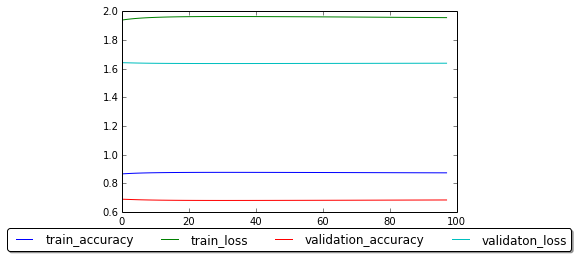

Generating data.
Generating features.
Starting optimization...
Early stopping.
Optimization Finished!


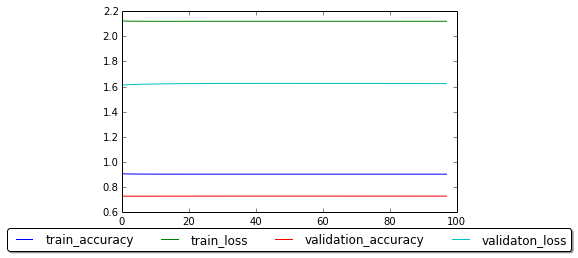

In [5]:
if __name__ == '__main__':
    n_nodes = 50
    n_graphs = 100
    m = MST_GCN(log=True)
    m.train_model(n_graphs=n_graphs, n_nodes=n_nodes, train_frac=0.5, val_frac=0.3, 
                  feature_gen=['weighted_degree'],
                  layer_config=[('gc', n_nodes, 'B'), ('d', 1, '')], 
                  dropouts=[False, False], test_n_nodes=int(n_nodes*0.8), verbose=False)
    m.plot_results()
    m.train_model(n_graphs=n_graphs, n_nodes=n_nodes, train_frac=0.5, val_frac=0.3, 
                  feature_gen=['weighted_degree'],
                  layer_config=[('gc', n_nodes, 'B'), ('d', 1, '')], 
                  dropouts=[False, False], test_n_nodes=None, verbose=False)
    m.plot_results()
else:
    print("MST_GCN imported.")